### Import Packages


In [ ]:
import os
import csv
import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

print(torch.__version__)

1.13.0+cu116


### MNIST dataset is provided in default

In [ ]:
train_path = './sample_data/mnist_train_small.csv'
test_path = './sample_data/mnist_test.csv'
img_size = 28

### Choose your device - use GPU or not?

In [ ]:
# device = 'cpu'
device = 'cuda'
print('Current Device : {}'.format(device))

Current Device : cuda


### Read the MNIST dataset
- total 1+ 28x28 dimension. 1 For Label, 28**2 for image


In [ ]:
def mnist_reader(file_path, img_size=img_size):
    total_img = list()
    total_label = list()
    with open(file_path) as csvfile:
        mnist_reader = csv.reader(csvfile)
        for row in tqdm(mnist_reader):
            img = np.array(row[1:], dtype=np.uint16).reshape(img_size, img_size)
            img = img / 255
            label = int(row[0])

            total_img.append(img)
            total_label.append(label)

    total_img = np.asarray(total_img)
    total_label = np.asarray(total_label)
    
    return total_img, total_label

In [ ]:
train_img, train_label = mnist_reader(train_path)
test_img, test_label = mnist_reader(test_path)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

### Define the Dataset

In [ ]:
class MNIST_Dataset(Dataset):
    def __init__(self, target_img, target_label):
        self.target_img = target_img
        self.target_label = target_label
        self.num_data = target_img.shape[0]

    def __len__(self):
        return self.num_data

    def __getitem__(self, idx):
        sample = dict()
        sample['img'] = self.target_img[idx]
        sample['label'] = self.target_label[idx]

        return sample

### Define the DataLoader

In [ ]:
# only train dataset (because it's generative model)
batch_size = 64

train_dataset = MNIST_Dataset(train_img, train_label)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

### Try to sample out one data point from dataloader

In [ ]:
sample = next(iter(train_dataloader))
print(sample['img'].shape)
print(sample['label'].shape)

torch.Size([64, 28, 28])
torch.Size([64])


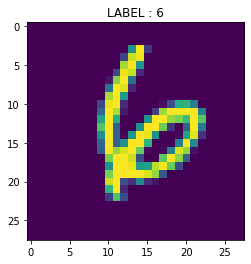

In [ ]:
plot_idx = 0
plt.imshow(sample['img'][plot_idx])
plt.title('LABEL : {}'.format(sample['label'][plot_idx]))
plt.show()

### Define the VAE (encoder + decoder)
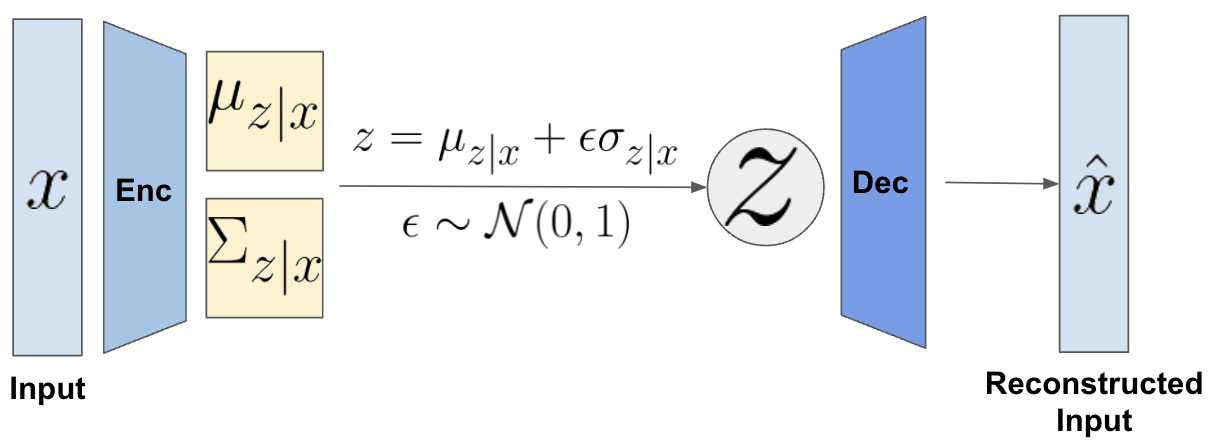

In [ ]:
class VAE(nn.Module):
    def __init__(self, dim_hidden_1, dim_hidden_2, dim_z, dim_input=img_size**2): # with MLP, img_size=28
        super(VAE, self).__init__()
        
        # define hidden dimension for encoder and decoder
        self.dim_hidden_1 = dim_hidden_1
        self.dim_hidden_2 = dim_hidden_2
        self.dim_z = dim_z
        self.dim_input = dim_input
        # self.dim_output = dim_input in VAE!

        # define encoder (light blue block)
        self.enc_1 = nn.Linear(dim_input, dim_hidden_1)
        self.enc_2 = nn.Linear(dim_hidden_1, dim_hidden_2)

        # encoder outputs (two yellow blocks)
        self.enc_z_mean = nn.Linear(dim_hidden_2, dim_z)
        self.enc_z_logvar = nn.Linear(dim_hidden_2, dim_z)
        # why logvar? 0 이상의 값만 있음 (0에 가까운 값이 많아 값이 바뀔 수 있음) -> log 취하는게 더 안정적

        # define decoder
        self.dec_1 = nn.Linear(dim_z, dim_hidden_2)
        self.dec_2 = nn.Linear(dim_hidden_2, dim_hidden_1)
        self.dec_3 = nn.Linear(dim_hidden_1, dim_input) # final output dimension = input dimension
    
        self.activation = nn.ReLU()

    def encoder(self, img):
        # img : B * H * W -> B * HW (HW = dim_input)
        batch_size = img.shape[0]
        input = img.view(batch_size, -1) # resize

        tmp_z = self.activation(self.enc_1(input))
        tmp_z = self.activation(self.enc_2(tmp_z))
        z_mean = self.enc_z_mean(tmp_z)
        z_logvar = self.enc_z_logvar(tmp_z)

        return z_mean, z_logvar

    def sampling(self, mean, logvar): # arrow
        std = torch.exp(0.5*logvar) # exp(0.5 * log(sigma^2)) = sigma
        eps = torch.randn_like(std) # dim_z (dimensional vec)
        z_sample = torch.mul(eps, std) + mean # sampling (reparameterization trick)
        return z_sample 
        
    def decoder(self, z_sample):
        out = self.activation(self.dec_1(z_sample))
        out = self.activation(self.dec_2(out))
        # we have data value between 0 ~ 1
        # so we are using sigmoid to fit into that range
        out = torch.sigmoid(self.dec_3(out))
        return out
    
    def forward(self, img):
        z_mean, z_logvar = self.encoder(img) # encode
        z_sample = self.sampling(z_mean, z_logvar) # sample
        # self.decoder(z_sample) -> reconstructed
        # z_mean, z_logvar : to calculate KL term in loss.
        return self.decoder(z_sample), z_mean, z_logvar # decode

### Define the Model

In [ ]:
dim_hidden_1 = 512
dim_hidden_2 = 256
dim_z = 128
model = VAE(dim_hidden_1, dim_hidden_2, dim_z)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
print(model)

VAE(
  (enc_1): Linear(in_features=784, out_features=512, bias=True)
  (enc_2): Linear(in_features=512, out_features=256, bias=True)
  (enc_z_mean): Linear(in_features=256, out_features=128, bias=True)
  (enc_z_logvar): Linear(in_features=256, out_features=128, bias=True)
  (dec_1): Linear(in_features=128, out_features=256, bias=True)
  (dec_2): Linear(in_features=256, out_features=512, bias=True)
  (dec_3): Linear(in_features=512, out_features=784, bias=True)
  (activation): ReLU()
)


#### Note that the KL dirvergence $D_{KL}(q_\phi(z|x^{(i)})\|p_\theta(z))$ is calculated as
#### -$\frac{1}{2}\sum_{j=1}^{J}\Big( 1 + \log((\sigma_j^{(i)})^2) - (\mu_j^{(i)})^2 - (\sigma_j^{(i)})^2 \Big)$

In [ ]:
def criterion(recon_img, img, z_mean, z_logvar):
    MSE_loss = nn.MSELoss(reduction='sum')(recon_img, img.view(-1, img_size**2)) # it is possible insead of BCE_loss!
    # reduction='sum' : effect of higher weight
    BCE_loss = F.binary_cross_entropy(recon_img, img.view(-1, img_size**2), reduction='sum') # range of input values : 0~1
    KL_loss = -0.5 * torch.sum(1 + z_logvar - z_mean**2 - torch.exp(z_logvar))
    coeff = 1.0 # larger coeff -> stronger structure of z, but small coeff makes better quality
    return MSE_loss + coeff * KL_loss

### Define functions for train/test

In [ ]:
def train(model, optimizer, sample):
    model.train()
    optimizer.zero_grad()

    img = sample['img'].float().to(device)
    
    recon_img, z_mean, z_logvar = model(img)

    curr_loss = criterion(recon_img, img, z_mean, z_logvar)

    curr_loss.backward()
    optimizer.step()

    return curr_loss.item()

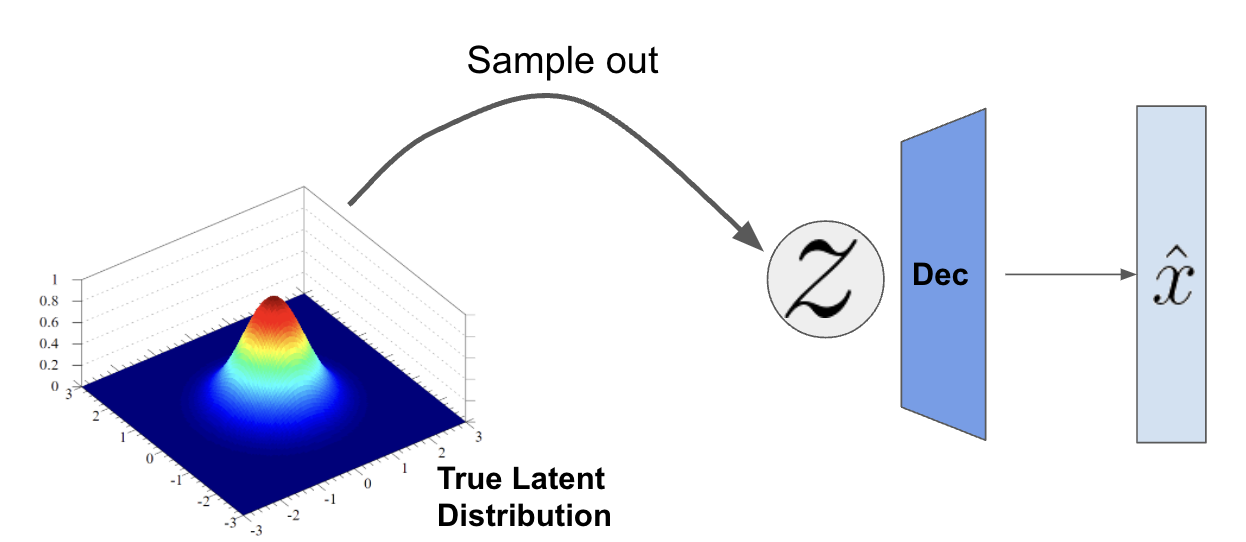

In [ ]:
def test(model):
    model.eval()
    with torch.no_grad():
        z_sample = torch.randn(1, dim_z).to(device) # sample from normal dist
        gen_out = model.decoder(z_sample)

    return gen_out.view(img_size, img_size).detach().cpu().numpy() # 28 * 28 -> able to plot with matplotlib

### Run Training

  0%|          | 0/100 [00:00<?, ?it/s]

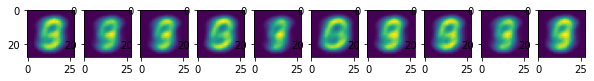

[EPOCH 0] SAMPLED TRAINING LOSS : 3260.1178399716737
[EPOCH 1] SAMPLED TRAINING LOSS : 3177.3985412402676
[EPOCH 2] SAMPLED TRAINING LOSS : 3123.598213561425
[EPOCH 3] SAMPLED TRAINING LOSS : 3071.7394508629923
[EPOCH 4] SAMPLED TRAINING LOSS : 3049.909669528754


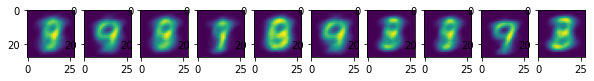

[EPOCH 5] SAMPLED TRAINING LOSS : 3033.7091672854654
[EPOCH 6] SAMPLED TRAINING LOSS : 3018.998854567067
[EPOCH 7] SAMPLED TRAINING LOSS : 3001.4212229183313
[EPOCH 8] SAMPLED TRAINING LOSS : 2979.413248957917
[EPOCH 9] SAMPLED TRAINING LOSS : 2942.560947016025


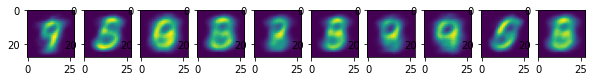

[EPOCH 10] SAMPLED TRAINING LOSS : 2899.1737860048925
[EPOCH 11] SAMPLED TRAINING LOSS : 2829.517898315819
[EPOCH 12] SAMPLED TRAINING LOSS : 2761.2928193796192
[EPOCH 13] SAMPLED TRAINING LOSS : 2726.5806681965096
[EPOCH 14] SAMPLED TRAINING LOSS : 2690.2652470890307


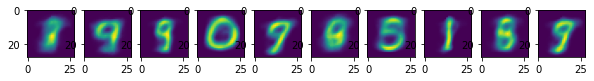

[EPOCH 15] SAMPLED TRAINING LOSS : 2657.4123964157357
[EPOCH 16] SAMPLED TRAINING LOSS : 2626.242162149937
[EPOCH 17] SAMPLED TRAINING LOSS : 2598.8150010764043
[EPOCH 18] SAMPLED TRAINING LOSS : 2569.674228266025
[EPOCH 19] SAMPLED TRAINING LOSS : 2545.888640674919


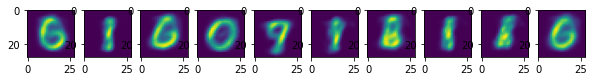

[EPOCH 20] SAMPLED TRAINING LOSS : 2527.115463695587
[EPOCH 21] SAMPLED TRAINING LOSS : 2505.9900853946165
[EPOCH 22] SAMPLED TRAINING LOSS : 2492.500787802018
[EPOCH 23] SAMPLED TRAINING LOSS : 2474.7522331457176
[EPOCH 24] SAMPLED TRAINING LOSS : 2464.105461339982


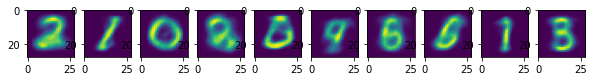

[EPOCH 25] SAMPLED TRAINING LOSS : 2453.481907853682
[EPOCH 26] SAMPLED TRAINING LOSS : 2440.4810518014933
[EPOCH 27] SAMPLED TRAINING LOSS : 2428.67008645542
[EPOCH 28] SAMPLED TRAINING LOSS : 2415.287546956118
[EPOCH 29] SAMPLED TRAINING LOSS : 2405.562211009259


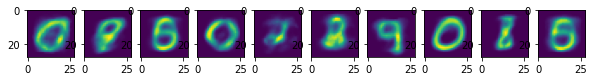

[EPOCH 30] SAMPLED TRAINING LOSS : 2391.475221676568
[EPOCH 31] SAMPLED TRAINING LOSS : 2380.4998439996016
[EPOCH 32] SAMPLED TRAINING LOSS : 2371.184037181135
[EPOCH 33] SAMPLED TRAINING LOSS : 2357.149179281899
[EPOCH 34] SAMPLED TRAINING LOSS : 2345.9450043992097


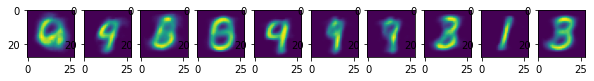

[EPOCH 35] SAMPLED TRAINING LOSS : 2330.9630411653866
[EPOCH 36] SAMPLED TRAINING LOSS : 2322.462762704673
[EPOCH 37] SAMPLED TRAINING LOSS : 2314.4428582237156
[EPOCH 38] SAMPLED TRAINING LOSS : 2298.20383948183
[EPOCH 39] SAMPLED TRAINING LOSS : 2286.744031034721


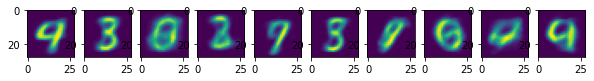

[EPOCH 40] SAMPLED TRAINING LOSS : 2275.903111271965
[EPOCH 41] SAMPLED TRAINING LOSS : 2260.6627852467295
[EPOCH 42] SAMPLED TRAINING LOSS : 2250.2148940601296
[EPOCH 43] SAMPLED TRAINING LOSS : 2242.2037236515325
[EPOCH 44] SAMPLED TRAINING LOSS : 2228.2852459502296


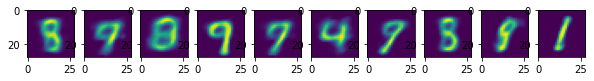

[EPOCH 45] SAMPLED TRAINING LOSS : 2215.037211360261
[EPOCH 46] SAMPLED TRAINING LOSS : 2203.2733497497757
[EPOCH 47] SAMPLED TRAINING LOSS : 2196.7766007980986
[EPOCH 48] SAMPLED TRAINING LOSS : 2188.9451069694737
[EPOCH 49] SAMPLED TRAINING LOSS : 2182.76422762642


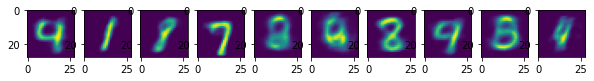

[EPOCH 50] SAMPLED TRAINING LOSS : 2173.437033948806
[EPOCH 51] SAMPLED TRAINING LOSS : 2165.5213502146566
[EPOCH 52] SAMPLED TRAINING LOSS : 2158.584662586737
[EPOCH 53] SAMPLED TRAINING LOSS : 2154.9270776133194
[EPOCH 54] SAMPLED TRAINING LOSS : 2146.4600732577883


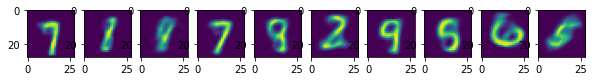

[EPOCH 55] SAMPLED TRAINING LOSS : 2141.8949070159615
[EPOCH 56] SAMPLED TRAINING LOSS : 2132.8773762760834
[EPOCH 57] SAMPLED TRAINING LOSS : 2126.636606819714
[EPOCH 58] SAMPLED TRAINING LOSS : 2119.710169978036
[EPOCH 59] SAMPLED TRAINING LOSS : 2112.0387797492763


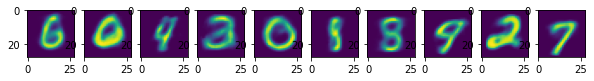

[EPOCH 60] SAMPLED TRAINING LOSS : 2106.3302583054624
[EPOCH 61] SAMPLED TRAINING LOSS : 2101.473408561927
[EPOCH 62] SAMPLED TRAINING LOSS : 2094.373747511794
[EPOCH 63] SAMPLED TRAINING LOSS : 2089.021367764701
[EPOCH 64] SAMPLED TRAINING LOSS : 2084.7603100663946


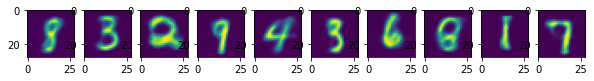

[EPOCH 65] SAMPLED TRAINING LOSS : 2077.6857184754404
[EPOCH 66] SAMPLED TRAINING LOSS : 2073.1706971969843
[EPOCH 67] SAMPLED TRAINING LOSS : 2069.101705630367
[EPOCH 68] SAMPLED TRAINING LOSS : 2063.792352938422
[EPOCH 69] SAMPLED TRAINING LOSS : 2058.507914680262


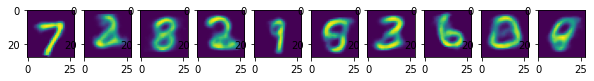

[EPOCH 70] SAMPLED TRAINING LOSS : 2056.343037858177
[EPOCH 71] SAMPLED TRAINING LOSS : 2050.0859351599943
[EPOCH 72] SAMPLED TRAINING LOSS : 2048.1115309255197
[EPOCH 73] SAMPLED TRAINING LOSS : 2044.142503244808
[EPOCH 74] SAMPLED TRAINING LOSS : 2037.5096671497472


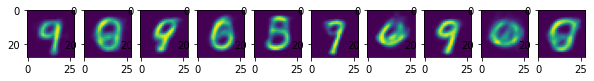

[EPOCH 75] SAMPLED TRAINING LOSS : 2033.712290413463
[EPOCH 76] SAMPLED TRAINING LOSS : 2029.0717145535903
[EPOCH 77] SAMPLED TRAINING LOSS : 2027.7094627112247
[EPOCH 78] SAMPLED TRAINING LOSS : 2024.5274114151732
[EPOCH 79] SAMPLED TRAINING LOSS : 2020.263615909858


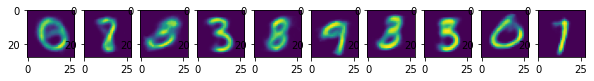

[EPOCH 80] SAMPLED TRAINING LOSS : 2015.082537861297
[EPOCH 81] SAMPLED TRAINING LOSS : 2013.408119664787
[EPOCH 82] SAMPLED TRAINING LOSS : 2007.0200226512593
[EPOCH 83] SAMPLED TRAINING LOSS : 2004.5781985151875
[EPOCH 84] SAMPLED TRAINING LOSS : 2002.6931398044374


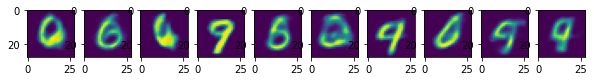

[EPOCH 85] SAMPLED TRAINING LOSS : 1999.472488549572
[EPOCH 86] SAMPLED TRAINING LOSS : 1996.9251324833397
[EPOCH 87] SAMPLED TRAINING LOSS : 1995.549375296401
[EPOCH 88] SAMPLED TRAINING LOSS : 1992.2725763777962
[EPOCH 89] SAMPLED TRAINING LOSS : 1986.8963506046575


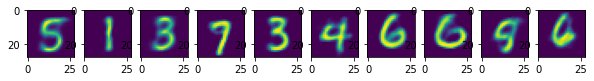

[EPOCH 90] SAMPLED TRAINING LOSS : 1988.14181645305
[EPOCH 91] SAMPLED TRAINING LOSS : 1983.191368029902
[EPOCH 92] SAMPLED TRAINING LOSS : 1980.8041153685365
[EPOCH 93] SAMPLED TRAINING LOSS : 1978.9245348068087
[EPOCH 94] SAMPLED TRAINING LOSS : 1974.1774566942888


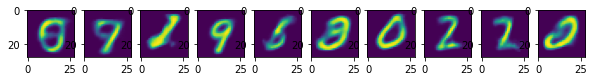

[EPOCH 95] SAMPLED TRAINING LOSS : 1974.3082359240836
[EPOCH 96] SAMPLED TRAINING LOSS : 1973.5344212931188
[EPOCH 97] SAMPLED TRAINING LOSS : 1969.9167757369453
[EPOCH 98] SAMPLED TRAINING LOSS : 1965.8507838630073
[EPOCH 99] SAMPLED TRAINING LOSS : 1964.21131619097


In [ ]:
max_epoch = 100

for epoch in tqdm(range(max_epoch)):        
    ###Train Phase
    
    # Initialize Loss
    train_loss = 0.0

    # Iterate over the train_dataloader
    for idx, sample in enumerate(train_dataloader):
        curr_loss = train(model, optimizer, sample)
        train_loss += curr_loss / len(train_dataloader)
    
    if epoch % 5 == 0:
        fig, ax = plt.subplots(1, 10, figsize=(10, 3))
        for i in range(10):
            ax[i].imshow(test(model))
        plt.pause(0.01)
        
    print('[EPOCH {}] SAMPLED TRAINING LOSS : {}'.format(epoch, train_loss))

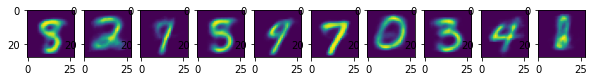

In [ ]:
fig, ax = plt.subplots(1, 10, figsize=(10, 3))
for i in range(10):
    ax[i].imshow(test(model))